**Task Description**

Goal:
The objective of the network optimization team is to analyze traces of past activity, which will be used to train an ML system capable of classifying samples of current activity as:
• 0 (normal): current activity corresponds to normal behavior of any working day and. Therefore, no re-configuration or redistribution of resources is needed.
• 1 (unusual): current activity slightly differs from the behavior usually observed for that time of the day (e.g. due to a strike, demonstration, sports event, etc.), which should trigger a reconfiguration of the base station.

**Table of  Content**

- 1. Importing library

- 2. Data set overview
    - 2.1 Training dataset
    - 2.2 Test dataset
  
- 3. Exploratory data analysis and feature engineering
    - 3.1 Numerical features
        - 3.1.1 Variability
        - 3.1.2 Missing values
        - 3.1.3 Multicollinearity
    - 3.2 Categorical features
        - 3.2.1 Missing values
        - 3.2.2 Target variable vs features

- 4. Modeling
    - 4.1 Split train dataset
    - 4.2 Preprocessing pipeline
    - 4.3 Modeling performance metrics
    - 4.4 Logistic regression model
    - 4.5 Random forest model

- 5. Prediction


**Content:**

The dataset has been obtained from a real LTE deployment. During two weeks, different metrics were gathered from a set of 10 base stations, each having a different number of cells, every 15 minutes. The dataset is provided in the form of a csv file, where each row corresponds to a sample obtained from one particular cell at a certain time. Each data example contains the following features:

- Time : hour of the day (in the format hh:mm) when the sample was generated.
- CellName1: text string used to uniquely identify the cell that generated the current sample. CellName is in the form xαLTE, where x identifies the base station, and α the cell within that base station (see the example in the right figure).
- PRBUsageUL and PRBUsageDL: level of resource utilization in that cell measured as the portion of Physical Radio Blocks (PRB) that were in use (%) in the previous 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
- meanThrDL and meanThrUL: average carried traffic (in Mbps) during the past 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
- maxThrDL and maxThrUL: maximum carried traffic (in Mbps) measured in the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
- meanUEDL and meanUEUL: average number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
- maxUEDL and maxUEUL: maximum number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
- maxUE_UL+DL: maximum number of user equipment (UE) devices that were active simultaneously in the last 15 minutes, regardless of UL and DL.

- Unusual: labels for supervised learning. A value of 0 determines that the sample corresponds to normal operation, a value of 1 identifies unusual behavior.

# Importing library

In [489]:
import pandas as pd
import numpy as np
import sklearn

#Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns

In [490]:
# Import packages for model building
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PowerTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [491]:
# Import packages for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import make_scorer

In [492]:
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [493]:
import time
t0 = time.time()

In [494]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# Data overview

## Training dataset

In [495]:
# Load train data
train_raw = pd.read_csv('ML-MATT-CompetitionQT1920_train.csv')
train_raw.head()

,Time,CellName,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL,Unusual
0,10:45,3BLTE,11.642,1.393,0.370,0.041,15.655,0.644,1.114,1.025,4.0,3.0,7,1
1,9:45,1BLTE,21.791,1.891,0.537,0.268,10.273,1.154,1.353,1.085,6.0,4.0,10,1
2,7:45,9BLTE,0.498,0.398,0.015,0.010,0.262,0.164,0.995,0.995,1.0,1.0,2,1
3,2:45,4ALTE,1.891,1.095,0.940,0.024,60.715,0.825,1.035,0.995,2.0,2.0,4,1
4,3:30,10BLTE,0.303,0.404,0.016,0.013,0.348,0.168,1.011,1.011,2.0,1.0,3,0


In [496]:
# Check duplicate records
train_raw.duplicated().any()

True

In [497]:
train_raw.drop_duplicates(inplace=True)

In [498]:
# Shape and data type
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36798 entries, 0 to 36903
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         36798 non-null  object 
 1   CellName     36798 non-null  object 
 2   PRBUsageUL   36798 non-null  float64
 3   PRBUsageDL   36798 non-null  float64
 4   meanThr_DL   36798 non-null  float64
 5   meanThr_UL   36798 non-null  float64
 6   maxThr_DL    36798 non-null  float64
 7   maxThr_UL    36798 non-null  float64
 8   meanUE_DL    36798 non-null  float64
 9   meanUE_UL    36798 non-null  float64
 10  maxUE_DL     36709 non-null  float64
 11  maxUE_UL     36709 non-null  float64
 12  maxUE_UL+DL  36793 non-null  object 
 13  Unusual      36798 non-null  int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 4.2+ MB


### Dependent variable

In [499]:
y = train_raw['Unusual']

In [500]:
# Check missing value; records with missing label should be removed
y.isnull().sum()

0

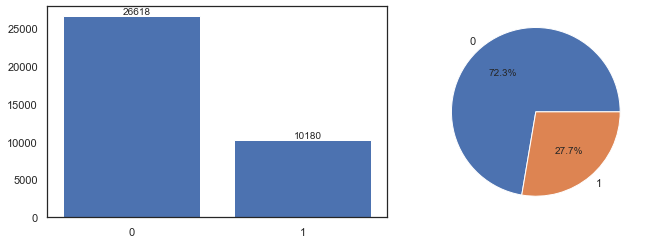

In [501]:
# Check value distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
axes[0].bar(["0", "1"],y.value_counts())
for i, v in enumerate(y.value_counts()):
    axes[0].text(i-0.05, v+300, str(v))
axes[1].pie(y.value_counts(), labels=["0", "1"], 
            autopct='%1.1f%%')
fig.tight_layout()

**Observation**: The training dataset exhibited some degree of imbalance (i.e., 27.6% label "1"), which should be accounted when building the model later on.

## Feature Investigation and Engineering

In [502]:
X_raw=train_raw

In [503]:
object_v = list(X_raw.select_dtypes(include=['object']).columns)
object_v

['Time', 'CellName', 'maxUE_UL+DL']

#### Conclusion
1. Time needs to be transformed into datetime format
2. CellName: might not be meaning for for our analysis
3. Features ('maxUE_UL+DL', 'maxUE_DL_median') to investigate

In [504]:
list(X_raw.select_dtypes(include=['float64']).columns)

['PRBUsageUL',
 'PRBUsageDL',
 'meanThr_DL',
 'meanThr_UL',
 'maxThr_DL',
 'maxThr_UL',
 'meanUE_DL',
 'meanUE_UL',
 'maxUE_DL',
 'maxUE_UL']

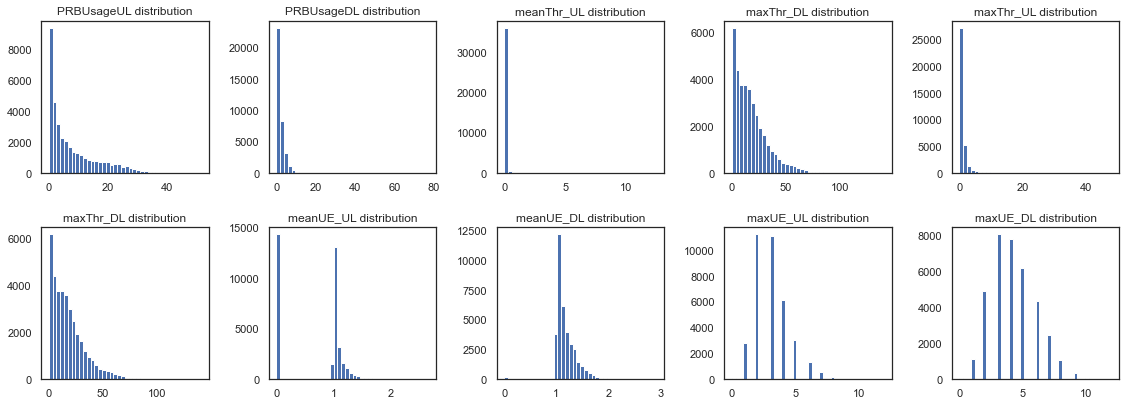

In [505]:
import warnings
warnings.filterwarnings('ignore')

float_v = list(X_raw.select_dtypes(include=['float64']).columns)

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7,  ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(16,6))
axs='ax'+str(i+1)

ax1.hist(X_raw.PRBUsageUL, bins=40)
ax1.set_title('PRBUsageUL distribution')
ax2.hist(X_raw.PRBUsageDL, bins=40)
ax2.set_title('PRBUsageDL distribution')

ax3.hist(X_raw.meanThr_UL, bins=40)
ax3.set_title('meanThr_UL distribution')
ax4.hist(X_raw.maxThr_DL, bins=40)
ax4.set_title('maxThr_DL distribution')

ax5.hist(X_raw.maxThr_UL, bins=40)
ax5.set_title('maxThr_UL distribution')
ax6.hist(X_raw.maxThr_DL, bins=40)
ax6.set_title('maxThr_DL distribution')

ax7.hist(X_raw.meanUE_UL, bins=40)
ax7.set_title('meanUE_UL distribution')
ax8.hist(X_raw.meanUE_DL, bins=40)
ax8.set_title('meanUE_DL distribution')

ax9.hist(X_raw.maxUE_UL, bins=40)
ax9.set_title('maxUE_UL distribution')
ax10.hist(X_raw.maxUE_DL, bins=40)
ax10.set_title('maxUE_DL distribution')
fig.tight_layout(pad=2.0)
plt.show()


### Key observations:
1. potential outliers in PRBUsageDL, maxThr_UL, maxUE_UL; are the outliers associate with unusal behavior?
2. meanUS_UL has many zeros. Is this associate with unsual behavior? We need to look into labeled charts

4. 'PRBUsageUL', 'PRBUsageDL', 'maxThr_DL' are log normal distributed. We may want to test on log transformation to see if it improves prediction accuracy

**Check univariate distribution of raw data, what are the key observations?**

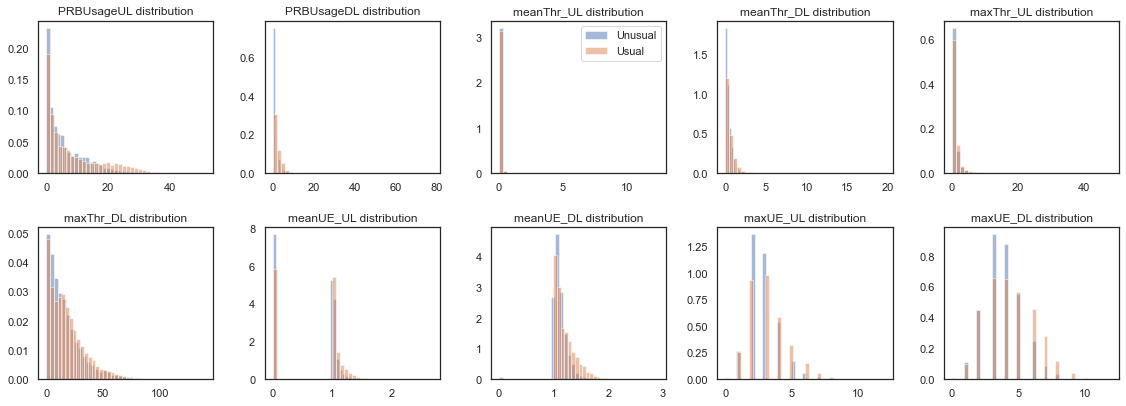

In [506]:
import warnings
warnings.filterwarnings('ignore')

printmd('**Check univariate distribution of raw data, what are the key observations?**')


float_v = list(train_raw.loc[train_raw['Unusual']==1].select_dtypes(include=['float64']).columns)

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7,  ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(16,6))
axs='ax'+str(i+1)

ax1.hist(train_raw.loc[train_raw['Unusual']==1].PRBUsageUL, alpha=0.5, bins=40, density=True, label='Unusual')
ax1.hist(train_raw.loc[train_raw['Unusual']==0].PRBUsageUL, alpha=0.5, bins=40, density=True, label='Usual')
ax1.set_title('PRBUsageUL distribution')
ax2.hist(train_raw.loc[train_raw['Unusual']==1].PRBUsageDL, alpha=0.5, bins=40, density=True, label='Unusual')
ax2.hist(train_raw.loc[train_raw['Unusual']==0].PRBUsageDL, alpha=0.5, bins=40, density=True, label='Usual')
ax2.set_title('PRBUsageDL distribution')

ax3.hist(train_raw.loc[train_raw['Unusual']==1].meanThr_UL, alpha=0.5, bins=40, density=True, label='Unusual')
ax3.hist(train_raw.loc[train_raw['Unusual']==0].meanThr_UL, alpha=0.5, bins=40, density=True, label='Usual')
ax3.set_title('meanThr_UL distribution')
ax4.hist(train_raw.loc[train_raw['Unusual']==1].meanThr_DL, alpha=0.5, bins=40, density=True, label='Unusual')
ax4.hist(train_raw.loc[train_raw['Unusual']==0].meanThr_DL, alpha=0.5, bins=40, density=True, label='Usual')
ax4.set_title('meanThr_DL distribution')

ax5.hist(train_raw.loc[train_raw['Unusual']==1].maxThr_UL, alpha=0.5, bins=40, density=True, label='Unusual')
ax5.hist(train_raw.loc[train_raw['Unusual']==0].maxThr_UL, alpha=0.5, bins=40, density=True, label='Usual')
ax5.set_title('maxThr_UL distribution')

ax6.hist(train_raw.loc[train_raw['Unusual']==1].maxThr_DL, alpha=0.5, bins=40, density=True, label='Unusual')
ax6.hist(train_raw.loc[train_raw['Unusual']==0].maxThr_DL, alpha=0.5, bins=40, density=True, label='Usual')
ax6.set_title('maxThr_DL distribution')

ax7.hist(train_raw.loc[train_raw['Unusual']==1].meanUE_UL, alpha=0.5, bins=40, density=True, label='Unusual')
ax7.hist(train_raw.loc[train_raw['Unusual']==0].meanUE_UL, alpha=0.5, bins=40, density=True, label='Usual')
ax7.set_title('meanUE_UL distribution')
ax8.hist(train_raw.loc[train_raw['Unusual']==1].meanUE_DL, alpha=0.5, bins=40, density=True, label='Unusual')
ax8.hist(train_raw.loc[train_raw['Unusual']==0].meanUE_DL, alpha=0.5, bins=40, density=True, label='Usual')
ax8.set_title('meanUE_DL distribution')

ax9.hist(train_raw.loc[train_raw['Unusual']==1].maxUE_UL, alpha=0.5, bins=40, density=True, label='Unusual')
ax9.hist(train_raw.loc[train_raw['Unusual']==0].maxUE_UL, alpha=0.5, bins=40, density=True, label='Usual')
ax9.set_title('maxUE_UL distribution')
ax10.hist(train_raw.loc[train_raw['Unusual']==1].maxUE_DL, alpha=0.5, bins=40, density=True, label='Unusual')
ax10.hist(train_raw.loc[train_raw['Unusual']==0].maxUE_DL, alpha=0.5, bins=40, density=True, label='Usual')
ax10.set_title('maxUE_DL distribution')
fig.tight_layout(pad=2.0)
ax3.legend(loc="best")
plt.show()


In [507]:
train_raw.columns

Index(['Time', 'CellName', 'PRBUsageUL', 'PRBUsageDL', 'meanThr_DL',
       'meanThr_UL', 'maxThr_DL', 'maxThr_UL', 'meanUE_DL', 'meanUE_UL',
       'maxUE_DL', 'maxUE_UL', 'maxUE_UL+DL', 'Unusual'],
      dtype='object')

def logtran(x):
    if x<=0:
        x=0.01
    else:
        x=np.log(x)
    return x

features=['PRBUsageUL', 'PRBUsageDL', 'meanThr_DL','meanThr_UL', 'maxThr_DL', 'maxThr_UL', 'meanUE_DL', 'meanUE_UL',]
for feature in features:
          X_raw[feature]=X_raw[feature].apply(logtran)

import warnings
warnings.filterwarnings('ignore')

float_v = list(X_raw.select_dtypes(include=['float64']).columns)

fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7,  ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(16,6))
axs='ax'+str(i+1)

ax1.hist(X_raw.PRBUsageUL, bins=40)
ax1.set_title('PRBUsageUL distribution')
ax2.hist(X_raw.PRBUsageDL, bins=40)
ax2.set_title('PRBUsageDL distribution')

ax3.hist(X_raw.meanThr_UL, bins=40)
ax3.set_title('meanThr_UL distribution')
ax4.hist(X_raw.maxThr_DL, bins=40)
ax4.set_title('maxThr_DL distribution')

ax5.hist(X_raw.maxThr_UL, bins=40)
ax5.set_title('maxThr_UL distribution')
ax6.hist(X_raw.maxThr_DL, bins=40)
ax6.set_title('maxThr_DL distribution')

ax7.hist(X_raw.meanUE_UL, bins=40)
ax7.set_title('meanUE_UL distribution')
ax8.hist(X_raw.meanUE_DL, bins=40)
ax8.set_title('meanUE_DL distribution')

ax9.hist(X_raw.maxUE_UL, bins=40)
ax9.set_title('maxUE_UL distribution')
ax10.hist(X_raw.maxUE_DL, bins=40)
ax10.set_title('maxUE_DL distribution')
fig.tight_layout(pad=2.0)
plt.show()


<AxesSubplot:>

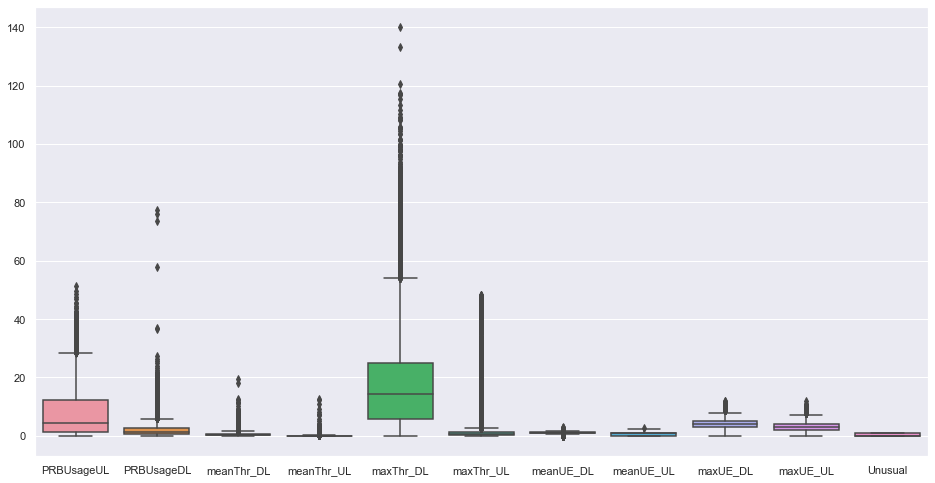

In [508]:
# axes[0].bar(["0", "1"],y.value_counts())
# for i, v in enumerate(y.value_counts()):
#     axes[0].text(i-0.05, v+300, str(v))
# axes[1].pie(y.value_counts(), labels=["0", "1"], 
#             autopct='%1.1f%%')
sns.set(rc={'figure.figsize':(16,8.27)})
fig.tight_layout()
sns.boxplot(data=X_raw)

**Note**: Server Outliers in many features. Normally, it is good time to talk to domain expert to figure out why; here we will try to handle outlier and check if it improves the prediction accuracy. Then decision will be made on the test

Apply IOR outlier handling on all variables

In [509]:
#remove outliers 
for feature in float_v:
    upperbound=X_raw[feature].quantile(0.999)
    X_raw.loc[(X_raw[feature]>upperbound),feature]=upperbound

### Key observations:
1.checked labeled plot there are some difference between usual-unusal data in features maxThr_DL,maxThr_UL; which migh prodive useful information for classify the data.

**independent and dependent variables, which features have high correlation with dependent var. and how about colinearlity?**

<AxesSubplot:>

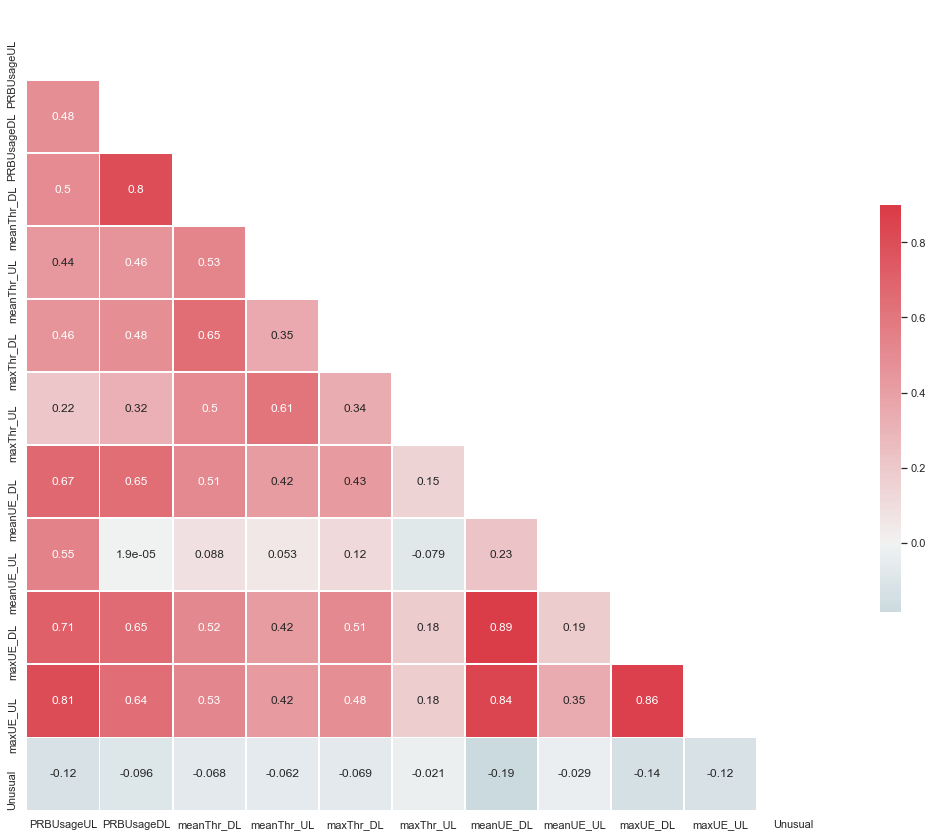

In [510]:
printmd('**independent and dependent variables, which features have high correlation with dependent var. and how about colinearlity?**')
sns.set(style="white")
features=float_v+['Unusual']
corr = train_raw[features].corr()

#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, annot=True, 
square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Observations: 
1. there is genmeral weak correlation between independent features and dependent variable
2. relatively good correlation beween independent variables such as 'PRBUsageUL', 'meanUE_DL', 'maxUE_DL', 'maxUE_UL'
3. there are strong collinearlity which will be handled in modeling stage

#### Action Plan
1. Let's handle outliers and apply logtransformation to check if it give us better corrlation with independent variables
2. We will also run sensitivity study to compare if remove outlier and log-transformation improve prediction accuracy

### Independent variables

In [511]:
X_raw = train_raw.drop('Unusual', 1)

In [512]:
# Per train_raw.info(), there are three types of variables based on data type
float_v = list(X_raw.select_dtypes(include=['float64']).columns)
# int_v = list(X_raw.select_dtypes(include=['int64']).columns)
object_v = list(X_raw.select_dtypes(include=['object']).columns)

In [513]:
# Value distribution of float_v
X_raw[float_v].describe()

,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL
count,36798.000000,36798.000000,36798.000000,36798.000000,36798.000000,36798.000000,36798.000000,36798.000000,36709.000000,36709.000000
mean,7.854148,2.101741,0.559920,0.065253,17.804884,1.796548,1.176451,0.666903,4.202158,3.071318
std,8.415566,2.099341,0.699604,0.105049,15.673823,5.029950,0.204688,0.534669,1.759134,1.376230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.213000,0.707000,0.142000,0.021000,5.770250,0.365000,1.041000,0.010000,3.000000,2.000000
50%,4.547000,1.393000,0.354000,0.040000,14.218000,0.706000,1.114000,1.011000,4.000000,3.000000
75%,12.139000,2.786000,0.720000,0.075000,25.118500,1.244000,1.263000,1.051000,5.000000,4.000000
max,38.925300,17.805503,6.724947,1.680639,96.235525,46.611436,2.290015,1.920000,10.000000,9.000000


**Observation**: Some variables have dramatically different scales (e.g., "x4" is distributed between [-5.14, 5.15] vs. "x41" between [94236.45, 105443.36], which may require scaling before building models. In addition, some variables (e.g., "x16") appear to have low variability. These variables may not contribute to model performance and can be deleted before building models. This aspect will be addressed in more depth in the EDA and feature engineering section.

In [514]:
# # Value distribution of int_v
# for v in int_v:
#     print('-------Value counts of {} in train dataset------\n'.format(v))
#     print(X_raw[v].value_counts(), '\n')

In [515]:
# Value distribution of object_v
for v in object_v:
    print('-------Value counts of {} in train dataset------\n'.format(v))
    print(X_raw[v].value_counts(), '\n')

-------Value counts of Time in train dataset------

12:00    423
3:00     411
9:45     410
7:30     409
9:00     406
        ... 
16:30    358
20:30    358
19:00    357
15:45    355
21:00    351
Name: Time, Length: 96, dtype: int64 

-------Value counts of CellName in train dataset------

5ALTE     1157
4CLTE     1150
4ALTE     1147
8ALTE     1142
8CLTE     1137
4BLTE     1134
6ALTE     1134
6VLTE     1134
6WLTE     1133
3CLTE     1131
5CLTE     1131
6ULTE     1129
7BLTE     1128
1ALTE     1122
10ALTE    1121
1CLTE     1120
7ULTE     1120
8BLTE     1118
1BLTE     1117
3BLTE     1117
10CLTE    1117
7WLTE     1116
9BLTE     1116
6BLTE     1112
10BLTE    1107
3ALTE     1107
5BLTE     1104
6CLTE     1102
9ALTE     1099
7CLTE     1096
7ALTE     1083
2ALTE     1010
7VLTE     1007
Name: CellName, dtype: int64 

-------Value counts of maxUE_UL+DL in train dataset------

5           5939
7           5322
8           3889
6           3883
9           3439
4           3391
10          2539
11    

**Observations**:
1. **x3**: This variable refers to dayofweek, but it contains two sets of values that needs to be hormonized. For example, "Monday" and "Mon" both refer to "Monday".
2. **x7**: This variable contains percent values and should be transformed to numeric data type.
3. **x19**: This variable contains dollar values and should be transformed to numeric data type.
4. **x24**: This variable contains gender information and can be treated as a categorical feature.
5. **x31**: This variable contains boolean values.
6. **x33**: This variable contains geographic information (i.e., states) and can be treated as a categorical feature.
7. **x39**: This variable only contains one value ("5-10 miles" for all 40000 records). Therefore, it should be removed before building models due to zero variability.
8. **x60**: This variable refers to monthofyear and can be treated as a categorical feature.
9. **x65**: This variable refers to the insurance provider and can be treated as a categorical feature.
10. **x77**: This variable refers to the automobile manufacturer and can be treated as a categorical feature.
11. **x93**: This variable contains boolean values.
12. **x99**: This variable contains "yes" for 27164 records. The missing values may need to be treated as a new level such as "unknown".

In [516]:
# Check missing values

def calculate_missing_perc(df):
    '''
    function: check the percentage of missing value of each column in a dataframe
    input: dataframe
    output: dataframe
    '''
    missing_values_count = pd.DataFrame({'Null':df.isnull().sum()})
    total = len(df)
    percentage_null = round((missing_values_count['Null']/total)*100,1)
    missing_values_count['Percentage'] = percentage_null
    missing_df = missing_values_count.sort_values(by='Null', ascending=False)
    
    # Only show the columns that have missing values
    missing_df = missing_df[missing_df['Null']>0]

    return missing_df

def plot_missing_perc(df):
    '''
    function: plot the percentage of missing value of each column in a dataframe
    input: dataframe
    output: barplot
    '''    
    plt.figure(figsize=(15,5))
    plt.bar(x=df.index, height=df['Percentage'])
    plt.ylabel('Percentage of missing values')
    plt.xticks(rotation=45)
    plt.show()

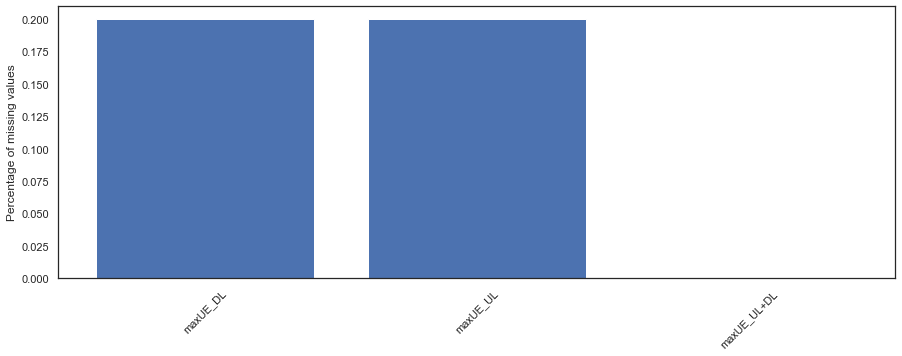

In [517]:
df_missing = calculate_missing_perc(train_raw)
plot_missing_perc(df_missing)

**Observations**: less than 0.2 percent of independent data are missing in data set. It might not make difference interm of modeling. For project skill demonstration, missing value will be handled in the EDA and feature engineering section.

## Test dataset

In [518]:
# Load test data
test = pd.read_csv('ML-MATT-CompetitionQT1920_test.csv')
test.head()

,Time,CellName,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL
0,3:00,6ALTE,3.781,1.493,0.575,0.042,22.659,0.743,0.985,0.010,3.0,2.0,5.0
1,20:30,6ULTE,2.021,3.335,0.569,0.075,29.265,1.049,1.314,0.010,6.0,3.0,9.0
2,11:30,2ALTE,0.505,0.404,0.014,0.010,0.227,0.097,1.011,0.010,2.0,1.0,3.0
3,6:45,3CLTE,1.011,0.505,0.238,0.021,20.962,0.609,1.011,1.011,2.0,1.0,3.0
4,15:45,6CLTE,3.881,0.498,0.076,0.041,3.936,1.768,1.025,0.010,3.0,2.0,5.0


In [519]:
# Shape and data type
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9158 entries, 0 to 9157
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         9158 non-null   object 
 1   CellName     9158 non-null   object 
 2   PRBUsageUL   9158 non-null   float64
 3   PRBUsageDL   9158 non-null   float64
 4   meanThr_DL   9158 non-null   float64
 5   meanThr_UL   9158 non-null   float64
 6   maxThr_DL    9158 non-null   float64
 7   maxThr_UL    9158 non-null   float64
 8   meanUE_DL    9158 non-null   float64
 9   meanUE_UL    9158 non-null   float64
 10  maxUE_DL     9156 non-null   float64
 11  maxUE_UL     9156 non-null   float64
 12  maxUE_UL+DL  9156 non-null   float64
dtypes: float64(11), object(2)
memory usage: 930.2+ KB


# Exploratory data analysis and feature engineering

__Review of names__
(see the long names in "Name Abbreviations HAI_Names_ID_xref.csv)

HAI_5 is for MRSA Bacteremia

| Short name | Description |
| :-- | :-- |
| HAI_5_CILOWER	| Lower Confidence Limit |
| HAI_5_CIUPPER	| Upper Confidence Limit | 
| HAI_5_DOPC	| Patient Days |
| HAI_5_ELIGCASES	|  Predicted Cases |
| HAI_5_NUMERATOR	|  Observed Cases |
| HAI_5_SIR	|  |

plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
X_raw.hist(ax = ax)

plt.show()

plt.figure(figsize=(16, 7))
X_raw_box=X_raw[['maxUE_DL', 'maxUE_UL']]
sns.boxplot(data=X_raw_box,palette='winter')

**Note** univariate boxplot shows large portion of outliers in independent vairables. will be handled in feature engineering, standarization and modeling method selection

In [520]:
# Build a class to select features
class FeatureSelector(BaseEstimator, TransformerMixin):
    """Sklearn transformer object to select certain columns
    """
    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.feature_names]

    def get_feature_names(self):
        return self.feature_names

## Numerical features

In [521]:
# obj2time_features = ['Time']
# obj2str_features = ['CellName']
removed_num_features = []
# df_num_features = float_v + obj2num_features
df_num_features = float_v

#1. imputation with median
def impute_nan_median(df,variable,median,extreme):
    '''
    impute nan with median of the variable
    '''
    df[variable+"_end_distribution"]=df[variable].fillna(extreme)
    df[variable].fillna(median,inplace=True)


In [522]:
#2. random sample imputation
def impute_nan_random(df,variable,median):
    '''
    Random sample imputation consists of taking random observation from the dataset 
    and we use this observation to replace the nan values
    '''
    df[variable+"_median"]=df[variable].fillna(median)
    df[variable+"_random"]=df[variable]
    ##It will have the random sample to fill the na
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    ##pandas need to have same index in order to merge the dataset
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable+'_random']=random_sample

X_raw.isnull().sum()

#3. imputation median
def impute_median(X):
        features=['maxUE_DL', 'maxUE_UL']
        for feature in features:
            if feature in X.columns:
                extreme=X[feature].mean()+3*X[feature].std()
                impute_nan_median(X, feature, X[feature].median, extreme)
                X.drop([feature+'_end_distribution'], axis=1, inplace=True) 
impute_median(X_raw)

X_raw.loc[X_raw['maxUE_DL'].isnull()]


impute_nan_random(X_raw, 'maxUE_DL', X_raw.maxUE_DL.median)

#3 linear imputation
def impute_nan_linear(df,variable):
    '''
    imputation by linear interpolation of rows above and below
    '''
    df[variable].interpolate(method='linear', limit_direction='forward', axis=0)

impute_nan_linear(X_raw, 'maxUE_DL')

In [ ]:
# Build a class to for feature engineering
class numeric_transformer(BaseEstimator, TransformerMixin):
    """Sklearn transformer object to transform string values to numeric values
    """
    def __init__(self): 
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):

# Missing value handleing

        # 1.imuputation:  fill with median 
        # Sensitivity Test
        features=['maxUE_DL', 'maxUE_UL']
        for feature in features:
            if feature in X.columns:
                extreme=X[feature].mean()+3*X[feature].std()
                X[feature+"_end_distribution"]=X[feature].fillna(extreme)
                X[feature].fillna(X[feature].median(),inplace=True)
                X.drop([feature+'_end_distribution'], axis=1, inplace=True) 

        # 2. imuputation: fill with distribution
        # Sensitivity Test
        features=['maxUE_DL', 'maxUE_UL']
        for feature in features:
            if feature in X.columns:
                random_sample=X[feature].dropna().sample(X[feature].isnull().sum(),random_state=0)
                ##pandas need to have same index in order to merge the dataset
                random_sample.index=X[X[feature].isnull()].index
                X.loc[X[feature].isnull(),feature]=random_sample
        
        #3. outliers treatment sensitivity: 
        #Observation: AUC for training data are the same and for test data AUC decrease 0.9012 to 0.9009
        for feature in float_v:
            upperbound=X[feature].quantile(0.999)
            X.loc[(X[feature]>upperbound),feature]=upperbound

        # log transformation of few features
          features=['PRBUsageUL', 'PRBUsageDL', 'meanThr_DL','meanThr_UL', 'maxThr_DL', 'maxThr_UL', 'meanUE_DL', 'meanUE_UL',]

        for feature in features:
            if feature in X.columns:
                  X_raw[feature]=X_raw[feature].apply(lambda x: np.log(x+1))
        self.X = X
        return self.X

    def get_feature_names(self):
        return self.X.columns.tolist()

In [523]:
# Build a class to transform "x7" and "x19" to numeric values
class numeric_transformer(BaseEstimator, TransformerMixin):
    """Sklearn transformer object to transform string values to numeric values
    """
    def __init__(self): 
        pass

    def fit(self, X, y=None):
        return self
    
    #1. imputation with median
#     def impute_nan_median(X,feature,median,extreme):
#         '''
#         impute nan with median of the feature
#         '''
#         X[feature+"_end_distribution"]=X[feature].fillna(extreme)
#         X[feature].fillna(median,inplace=True)
    
    def transform(self, X, y=None):
#         X_copy = X.copy()
#         if 'x7' in X.columns:
#             X_copy['x7'] = X_copy['x7'].map(
#                 lambda x: float(x.strip('%'))/100 if type(x)==str else x, na_action='ignore')
#         if 'x19' in X.columns:
#             X_copy['x19'] = X_copy['x19'].map(
#                 lambda x: float(x.strip('$')) if type(x)==str else x, na_action='ignore')  
# Missing value handleing

        # imuputation 1:  fill with median 2. fill with distribution
        # Sensitivity Test
#         features=['maxUE_DL', 'maxUE_UL']
#         for feature in features:
#             if feature in X.columns:
#                 extreme=X[feature].mean()+3*X[feature].std()
#                 X[feature+"_end_distribution"]=X[feature].fillna(extreme)
#                 X[feature].fillna(X[feature].median(),inplace=True)
#                 X.drop([feature+'_end_distribution'], axis=1, inplace=True) 
        # imuputation 2: use forward imputation 2. fill with median 3. fill with distribution
        # Sensitivity Test
        features=['maxUE_DL', 'maxUE_UL']
        for feature in features:
            if feature in X.columns:
#                 X[feature+"_median"]=X[feature].fillna(X[feature].median())
#                 X[feature+"_random"]=X[feature]
                ##It will have the random sample to fill the na
                random_sample=X[feature].dropna().sample(X[feature].isnull().sum(),random_state=0)
                ##pandas need to have same index in order to merge the dataset
                random_sample.index=X[X[feature].isnull()].index
                X.loc[X[feature].isnull(),feature]=random_sample
        
        #outliers treatment sensitivity: 
        #Observation: AUC for training data are the same and for test data AUC decrease 0.9012 to 0.9009
#         for feature in float_v:
#             upperbound=X[feature].quantile(0.999)
#             X.loc[(X[feature]>upperbound),feature]=upperbound

        # log transformation of few features
    
        


        features=['PRBUsageUL', 'PRBUsageDL', 'meanThr_DL','meanThr_UL', 'maxThr_DL', 'maxThr_UL', 'meanUE_DL', 'meanUE_UL',]

        for feature in features:
            if feature in X.columns:
                  X_raw[feature]=X_raw[feature].apply(lambda x: np.log(x+1))


        self.X = X
        return self.X

    def get_feature_names(self):
        return self.X.columns.tolist()

In [524]:
# Create a dataframe df_num for all numerical features
num_tfm = Pipeline(steps=[
    ('num_selector', FeatureSelector(df_num_features)),
    ('obj2num_tfm', numeric_transformer())
])

df_num = num_tfm.fit_transform(X_raw)
df_num.head()

,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL
0,11.642,1.393,0.370,0.041,15.655,0.644,1.114,1.025,4.0,3.0
1,21.791,1.891,0.537,0.268,10.273,1.154,1.353,1.085,6.0,4.0
2,0.498,0.398,0.015,0.010,0.262,0.164,0.995,0.995,1.0,1.0
3,1.891,1.095,0.940,0.024,60.715,0.825,1.035,0.995,2.0,2.0
4,0.303,0.404,0.016,0.013,0.348,0.168,1.011,1.011,2.0,1.0


In [525]:
df_num.isnull().sum()

PRBUsageUL    0
PRBUsageDL    0
meanThr_DL    0
meanThr_UL    0
maxThr_DL     0
maxThr_UL     0
meanUE_DL     0
meanUE_UL     0
maxUE_DL      0
maxUE_UL      0
dtype: int64

### Variability

In [526]:
# Check low variability features

s = pd.Series(df_num.describe().loc['std',:]\
    /df_num.describe().loc['mean',:], name='RelativeDeviation',
              index=pd.Index(df_num.columns, name='Feature'))
df_variabiblity = s.reset_index()
df_variabiblity.sort_values(by='RelativeDeviation',key=abs, inplace=True)
df_variabiblity.head()

,Feature,RelativeDeviation
6,meanUE_DL,0.173988
8,maxUE_DL,0.418585
9,maxUE_UL,0.448220
7,meanUE_UL,0.801720
4,maxThr_DL,0.880310


**Note**: 'x16' and 'x41' showed very low variabilbity. These features will not be used for building models. 

In [527]:
# removed_num_features.extend(['x16', 'x41'])
# remain_num_features = list(set(df_num_features)-set(removed_num_features))
remain_num_features = list(set(df_num_features))
# print('Removed numerical features:', removed_num_features)
print('Remaining numerical features:', remain_num_features)

Remaining numerical features: ['maxThr_DL', 'meanUE_UL', 'meanUE_DL', 'PRBUsageDL', 'meanThr_UL', 'maxThr_UL', 'maxUE_DL', 'maxUE_UL', 'meanThr_DL', 'PRBUsageUL']


### Missing values 

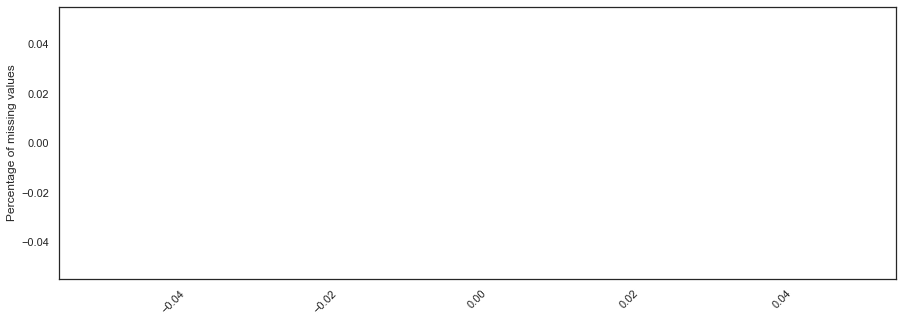

In [528]:
# Check missing values
df_missing = calculate_missing_perc(df_num)
plot_missing_perc(df_missing)

**Note**: 'MAXUE_DL' and 'MAXUE_UL' showed 0.20% of missing value and will be imputed before modeling. 

In [529]:
# removed_num_features.extend(['x44', 'x57', 'x30'])
# remain_num_features = list(set(df_num_features)-set(removed_num_features))
remain_num_features = list(set(df_num_features))
# print('Removed numerical features:', removed_num_features)
print('Remaining numerical features:', remain_num_features)

Remaining numerical features: ['maxThr_DL', 'meanUE_UL', 'meanUE_DL', 'PRBUsageDL', 'meanThr_UL', 'maxThr_UL', 'maxUE_DL', 'maxUE_UL', 'meanThr_DL', 'PRBUsageUL']


### Multicollinearity

<AxesSubplot:>

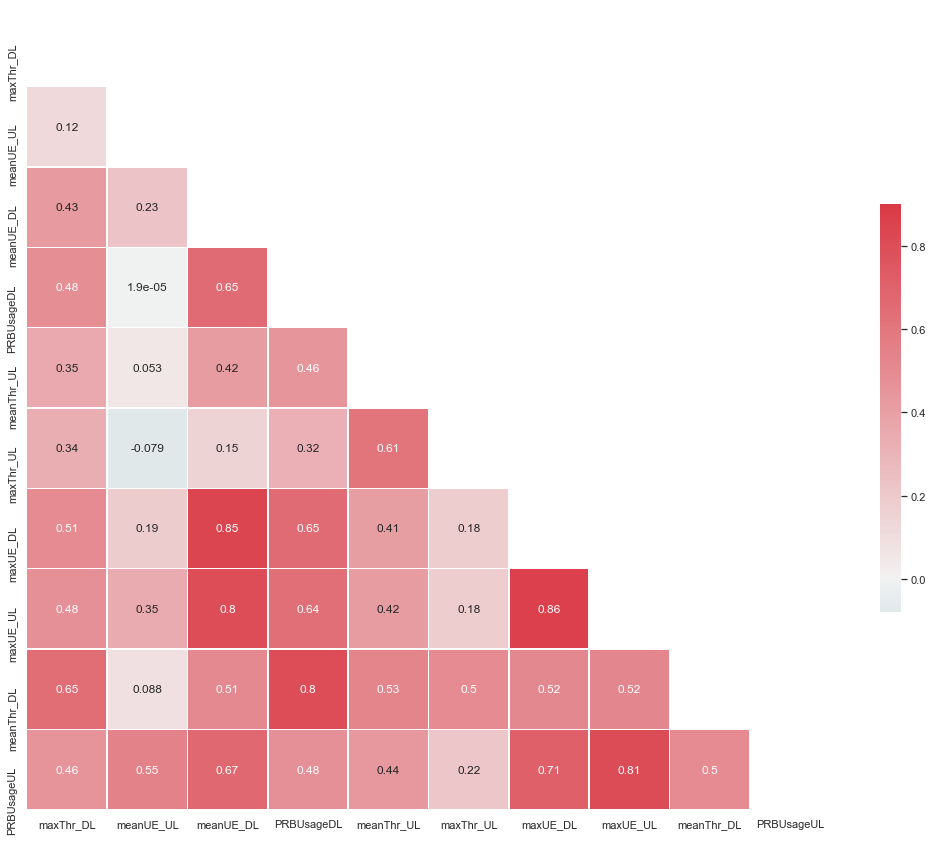

In [530]:
# Visualize the correlations among the numerical features
# figure(figsize=(20, 20), dpi=60)
# sns.heatmap(df_num[remain_num_features].corr(method='pearson'), annot=False,
#            cmap='coolwarm')
# plt.title('Heatmap of the numerical features', fontsize=15)
# plt.rc('xtick',labelsize=10)
# plt.rc('ytick',labelsize=10)
# plt.show()
 #plot heatmap mask half
#Set and compute the Correlation Matrix:

sns.set(style="white")
corr = df_num[remain_num_features].corr()

#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, annot=True, 
square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Note**: Multicollinearity may be present among the numerical features. This issue can be addressed by modeling approaches such as regularization.

## Categorical features

In [531]:
train_raw.head()

,Time,CellName,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL,Unusual
0,10:45,3BLTE,11.642,1.393,0.370,0.041,15.655,0.644,1.114,1.025,4.0,3.0,7,1
1,9:45,1BLTE,21.791,1.891,0.537,0.268,10.273,1.154,1.353,1.085,6.0,4.0,10,1
2,7:45,9BLTE,0.498,0.398,0.015,0.010,0.262,0.164,0.995,0.995,1.0,1.0,2,1
3,2:45,4ALTE,1.891,1.095,0.940,0.024,60.715,0.825,1.035,0.995,2.0,2.0,4,1
4,3:30,10BLTE,0.303,0.404,0.016,0.013,0.348,0.168,1.011,1.011,2.0,1.0,3,0


In [532]:
###need to check
from datetime import datetime
from pytz import timezone
import pytz

import time
t0 = time.time()

In [533]:
# df_cat_features = int_v + object_v
df_cat_features = object_v
removed_cat_features = []
remain_cat_features = list(set(df_cat_features)-set(['CellName']))
remain_cat_features

['maxUE_UL+DL', 'Time']

In [534]:
# Build a class to transform "x3" to consistent dayofweek values
class dayofweek_transformer(BaseEstimator, TransformerMixin):
    def __init__(self): 
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        if 'Time' in X.columns:
            X_copy['Time']=pd.to_datetime(X_copy['Time'], format='%H:%M').dt.hour
#               df['hour'] = pd.to_datetime(df['time'], format='%H:%M').dt.hour
#             df['ts'] = df.datetime.astype('int64') // 10**9
#             X["placed_order_hour"]=X['placed_order_Timestamp_Pac'].dt.hour
        self.df = X_copy
        return self.df

    def get_feature_names(self):
        return self.df.columns.tolist()

In [535]:
# Create a dataframe df_cat for all categorical features

cat_tfm = Pipeline(steps=[
    ('cat_selector', FeatureSelector(remain_cat_features)),
    ('dayofweek_tfm', dayofweek_transformer())    
])

df_cat = cat_tfm.fit_transform(X_raw)
df_cat.head()

,maxUE_UL+DL,Time
0,7,10
1,10,9
2,2,7
3,4,2
4,3,3


### Missing values

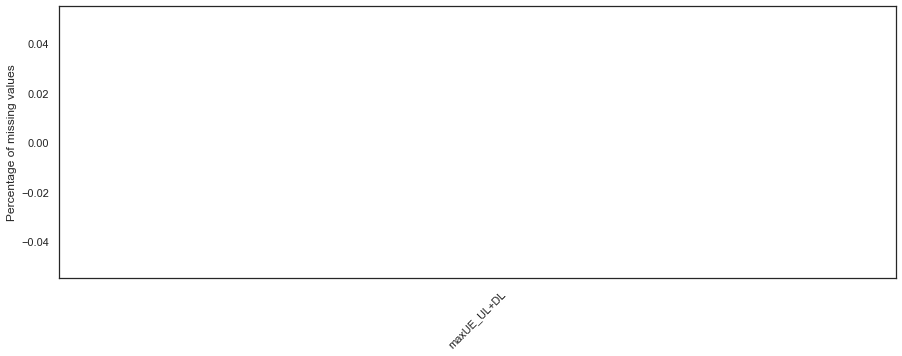

In [536]:
# Check missing values
df_missing = calculate_missing_perc(df_cat)
plot_missing_perc(df_missing)

**Note**: From the data overview section, we saw there is only one non-null value for x99. Common imputation strategy such as "most_frequent" will result in zero variance of this feature. 

In [537]:
removed_cat_features.extend(['Time'])
remain_cat_features = list(set(remain_cat_features)-set(removed_cat_features))
remain_cat_features = list(set(remain_cat_features))

print('Removed categorical features:', removed_cat_features)
print('Remaining categorical features:', remain_cat_features)

Removed categorical features: ['Time']
Remaining categorical features: ['maxUE_UL+DL']


In [538]:
# Alternatively, I tested adding a new level "unknown" to replace missing values

remain_cat_features2 = remain_cat_features 

class new_level_transformer(BaseEstimator, TransformerMixin):
    def __init__(self): 
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy.fillna('unknown',inplace=True)                        
        self.df = X_copy
        return self.df

    def get_feature_names(self):
        return self.df.columns.tolist()

### Target variable vs features

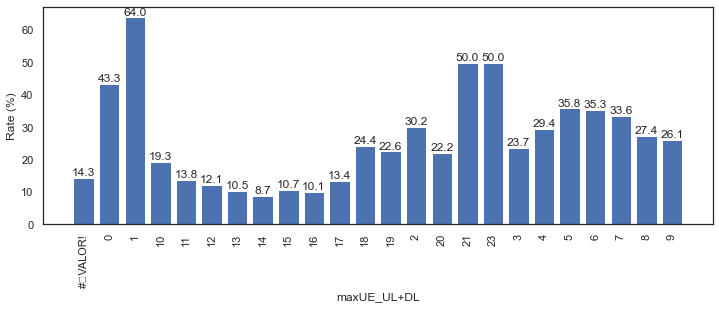

In [539]:
def plot_categorical(df, feature):

    feature_df = df.groupby(feature)["Unusual"].sum().reset_index()
    feature_df['Sum'] = df.groupby(feature)["Unusual"].count().values
    feature_df['Rate'] = feature_df["Unusual"].div(feature_df['Sum'])*100

    fig, axes = plt.subplots(figsize=(12, 4))
    plt.bar(feature_df[feature], feature_df['Rate'])
    if len(feature_df[feature])>5:
        plt.xticks(feature_df[feature], feature_df[feature],rotation='vertical')
    else:
        plt.xticks(feature_df[feature], feature_df[feature])

    plt.xlabel(feature)
    plt.ylabel('Rate (%)')

    labels = [str(round(i,1)) for i in feature_df['Rate']]

    for i in range(len(labels)):
        plt.text(feature_df[feature][i], feature_df['Rate'][i], labels[i], ha='center', va='bottom')

    plt.show()
        
for f in remain_cat_features:
    plot_categorical(df_cat.join(y), f)    

**Note**: For the remaining categorical features that have more than two levels (i.e., 'x33', 'x65', 'x3', 'x60', 'x77'), there is no evidence that any of the features has inherent ordering. Therefore, one-hot encoding will be applied to these features.

# Modeling

## Split train dataset

I held out 20% train data to test model performance.

In [540]:
y.shape

(36798,)

In [541]:
# split into train/test sets with same class ratio
trainX, testX, trainy, testy =\
    train_test_split(X_raw, y, test_size=0.2,
                     random_state=42, stratify=y)

# summarize dataset
print('Dataset: Class0=%d, Class1=%d' %
      (len(y[y==0]), len(y[y==1])))
print('Train: Class0=%d, Class1=%d' % 
      (len(trainy[trainy==0]), len(trainy[trainy==1])))
print('Test: Class0=%d, Class1=%d' % 
      (len(testy[testy==0]), len(testy[testy==1])))

Dataset: Class0=26618, Class1=10180
Train: Class0=21294, Class1=8144
Test: Class0=5324, Class1=2036


## Preprocessing pipeline

I tested different data transformation and imputation strategies:
- Power transformation of numerical features
- Fill missing values with 'mean' or 'median' for numerical features
- IterativeSimputer() for numerical features
- Fill 'most_frequent' value for categorical features
- Creat new level "unknown" to address missing values in the categorical features

Below is one of the best performing preprocessors considering both prediction score and speed.

In [542]:
num_tfm = Pipeline(steps=[
    ('num_selector', FeatureSelector(remain_num_features)),
    ('obj2num_tfm', numeric_transformer()),
#     ('imputer', SimpleImputer(strategy='median'))
#     ('imputer', IterativeImputer(max_iter=10, random_state=0))
      ('imputer', KNNImputer(n_neighbors=2, weights="uniform"))
])

cat_tfm = Pipeline(steps=[
    ('cat_selector', FeatureSelector(remain_cat_features)),
    ('dayofweek_tfm', dayofweek_transformer()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = FeatureUnion([
    ('num_tfm', num_tfm),
    ('cat_tfm', cat_tfm)
])

In [543]:
# Check if pipeline works properly
preprocessor.fit(trainX)
columns = remain_num_features + \
    preprocessor.transformer_list[1][1]['encoder'].get_feature_names().tolist()
pd.DataFrame(preprocessor.transform(trainX), columns=columns).head()

,maxThr_DL,meanUE_UL,meanUE_DL,PRBUsageDL,meanThr_UL,maxThr_UL,maxUE_DL,maxUE_UL,meanThr_DL,PRBUsageUL,x0_#�VALOR!,x0_0,x0_1,x0_10,x0_11,x0_12,x0_13,x0_14,x0_15,x0_16,x0_17,x0_18,x0_19,x0_2,x0_20,x0_21,x0_23,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9
0,1.373969,0.009950,0.698632,0.339325,0.023717,0.131028,1.0,1.0,0.125751,0.264669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.129126,0.009950,0.812263,2.113360,0.078811,0.461215,5.0,3.0,1.154678,0.794349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.516726,0.737642,0.834647,1.201169,0.079735,0.748582,6.0,4.0,0.484276,2.938421,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.761665,0.703592,0.723191,1.036382,0.044973,0.599386,3.0,2.0,0.680568,1.368639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.522952,0.009950,0.718327,0.473747,0.013903,0.286682,3.0,2.0,0.016857,2.291726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Model performance metrics

ROC AUC score was selected to evaluate model performance. The higher the score is, the better the model performs.

In [544]:
def plot_roc_auc(clf, X, y):

    y_pred = clf.predict(X)
    y_score = clf.predict_proba(X)[:,1]
    
    # ROC_AUC
    fpr, tpr, thres = roc_curve(y, y_score)
    auc_score = roc_auc_score(y, y_score)

    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y))]
    p_fpr, p_tpr, _ = roc_curve(y, random_probs)

    # plot roc curve
    plt.plot(fpr, tpr, color='black')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.rcParams['font.size'] = 14
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    bbox_prop = dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=2)
    plt.text(0.8, 0.2, "ROC AUC = {:.4f}".format(auc_score), ha="center", va="center",
                size=10, bbox=bbox_prop)
    plt.show()

## Logistic regression model

**Benchmark logistic regression model**

lr_clf_1 = Pipeline([
    ('prep', preprocessor),
    ('scaler', RobustScaler()),
    ('lr', LogisticRegression())
])

lr_clf_1.fit(trainX, trainy)

# Training score
plot_roc_auc(lr_clf_1, trainX, trainy)

# Test score
plot_roc_auc(lr_clf_1, testX, testy)

**Hyperparameter tuning for logistic regression model**

# define model
logreg = LogisticRegression()

# define hyperparameters
w = [{0:1,1:0.1}, {0:1,1:0.3}, {0:1,1:1}, {0:1,1:3}, {0:1,1:10}]
crange = [0.1, 0.3, 1, 3, 10]

param_grid = [
    {
        "class_weight": w,
        "C": crange,
        "solver": ['saga'],
        "penalty": ['elasticnet']
    },
    {
        "class_weight": w,
        "C": crange,
        "solver": ['lbfgs'],
        "penalty": ['l2']
    }
]
    
lr_gs = GridSearchCV(logreg, param_grid, 
                           cv=3, n_jobs=-1, scoring='roc_auc')

lr_gs_pipeline = Pipeline([
    ('prep', preprocessor),
    ('scaler', RobustScaler()),
    ('gs', lr_gs)
])

%%time

lr_gs_pipeline.fit(trainX,trainy)
best_params = lr_gs_pipeline[2].best_params_
best_params

# Build the model pipeline with the optimal hyperparameters

logreg = LogisticRegression(**best_params)

lr_clf_2 = Pipeline([
    ('prep', preprocessor),
    ('scaler', RobustScaler()),
    ('lr', logreg)])

lr_clf_2.fit(trainX, trainy)

# Test score
plot_roc_auc(lr_clf_2, testX, testy)

**Observations**: lr_clf_1 outperforms lr_clf_2, so lr_clf_1 will be retrained with the complete training dataset for results submission.

## Random forest model

In [545]:
# Create base model to tune

rf = RandomForestClassifier(
              class_weight="balanced",
              bootstrap=True,
              oob_score=True,
              n_jobs=-1,
              random_state=0,
              max_features='auto')


# Use GridSearchCV to tune hyperparameters.

param_grid = {'n_estimators': [100, 200, 300], 
              'max_depth': [3, 5, 10],
             'min_samples_leaf': [2, 3, 5], 
             'min_samples_split': range(30, 150, 30)} # I made a mistake, swapped min_samples_leaf and min_samples_split

rf_gs = GridSearchCV(rf, param_grid, 
                           cv=3, n_jobs=-1, scoring='roc_auc')

%%time

rf_gs_pipeline = Pipeline([
    ('prep', preprocessor),
    ('scaler', RobustScaler()),
    ('gs', rf_gs)
])

rf_gs_pipeline.fit(trainX, trainy)

best_params = rf_gs_pipeline[2].best_params_
best_params

In [546]:
best_params={'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 30,
 'n_estimators': 300}

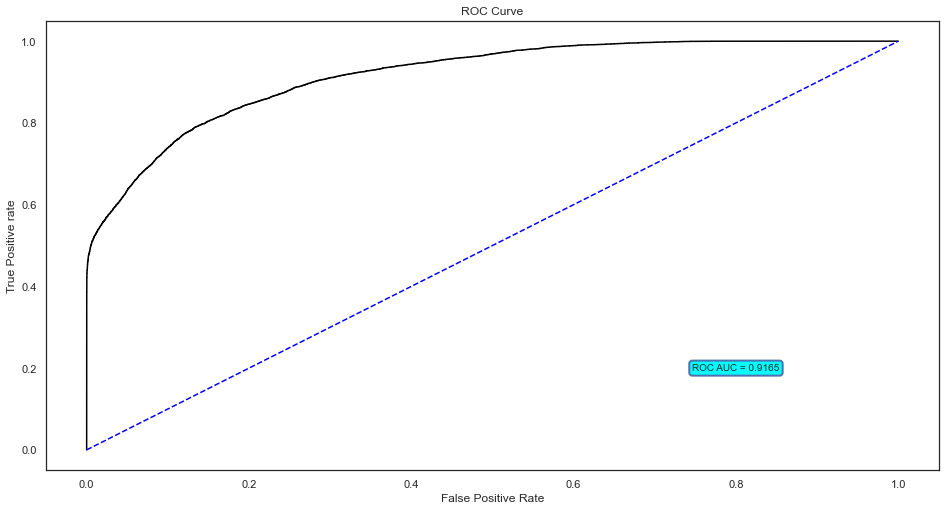

In [547]:
# Build the model pipeline with the optimal hyperparameters

rf = RandomForestClassifier(
              class_weight="balanced",
              bootstrap=True,
              oob_score=True,
              n_jobs=-1,
              random_state=0,
              max_features='auto',
              **best_params)

rf_clf_1 = Pipeline([
    ('prep', preprocessor),
    ('scaler', RobustScaler()),
    ('rf', rf)])

rf_clf_1.fit(trainX, trainy)

# Train score
plot_roc_auc(rf_clf_1, trainX, trainy)

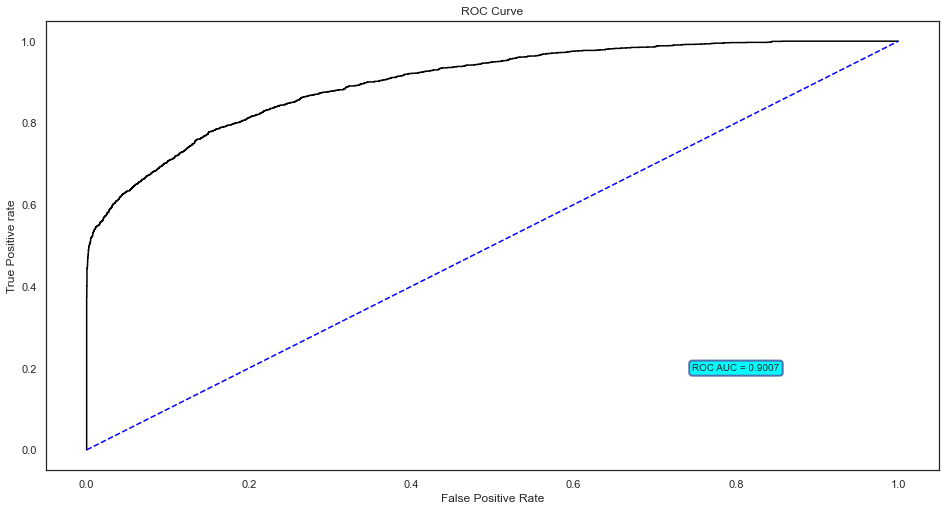

In [548]:
# Test score
plot_roc_auc(rf_clf_1, testX, testy)

In [549]:
rf_clf_1.named_steps['rf']

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=30,
                       n_estimators=300, n_jobs=-1, oob_score=True,
                       random_state=0)

In [550]:
# SimpleImputer, IterativeImputer, KNNImputer

onehot_columns=rf_clf_1.named_steps['prep'].transformer_list[1][1][3].get_feature_names(input_features=remain_cat_features)
numeric_features_list = list(remain_num_features)
numeric_features_list.extend(onehot_columns)

importances = list(zip(zip(rf_clf_1.named_steps['rf'].feature_importances_, numeric_features_list)))
importances.sort(reverse=True)

std = np.std([
    tree.feature_importances_ for tree in rf_clf_1.steps[2][1].estimators_], axis=0)

from sklearn.inspection import permutation_importance
forest_importances = pd.Series(importances, index=feature_names)

forest_importances[:10]

#Create a feature importance plot
# importances = rf_clf_1.steps[2][1].feature_importances_
onehot_columns=rf_clf_1.named_steps['prep'].transformer_list[1][1][3].get_feature_names(input_features=remain_cat_features)
numeric_features_list = list(remain_num_features)
numeric_features_list.extend(onehot_columns)
# result = [ [x[1], x[0]] for x in zip(rf_clf_1.named_steps['rf'].feature_importances_, numeric_features_list)]
# importances = list(zip(rf_clf_1.named_steps['rf'].feature_importances_, numeric_features_list))
importances = rf_clf_1.named_steps['rf'].feature_importances_

std = np.std([
    tree.feature_importances_ for tree in rf_clf_1.steps[2][1].estimators_], axis=0)

from sklearn.inspection import permutation_importance
forest_importances = pd.Series(importances, index=numeric_features_list)

# select top 12 features
forest_importances=forest_importances[:12]
std=std[:12]

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.set_size_inches(18.5, 15)

# Prediction

lr_clf_1.fit(X_raw, y)

test = pd.read_csv('ML-MATT-CompetitionQT1920_test.csv')
test.head()

lr_clf_1.fit(X_raw, y)
glmresults = lr_clf_1.predict(test)

%%time
lr_clf_1.fit(X_raw, y)
glmresults = lr_clf_1.predict_proba(test)[:,1]
glmresults = pd.DataFrame(glmresults)
glmresults.to_csv(r'glmresults.csv', index=False, header=False)

%%time
rf_clf_1.fit(X_raw, y)
nonglmresults = rf_clf_1.predict_proba(test)[:,1]
nonglmresults = pd.DataFrame(nonglmresults)
nonglmresults.reset_index(inplace=True)
nonglmresults.columns=['Id','Label']
nonglmresults.set_index('Id')

nonglmresults.to_csv(r'nonglmresults.csv', index=False, header=True)

t1 = time.time()
total = t1-t0
print("mins:",total/60)